In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, preprocessing,linear_model, metrics, pipeline , ensemble,neighbors

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [10.0, 6.0]

%matplotlib inline

In [3]:
train = pd.read_csv('../../datasets/titanic/train.csv')
test = pd.read_csv('../../datasets/titanic/test.csv')
submission = pd.read_csv('../../datasets/titanic/gender_submission.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
train['Pclass'] = train['Pclass'].astype('object')

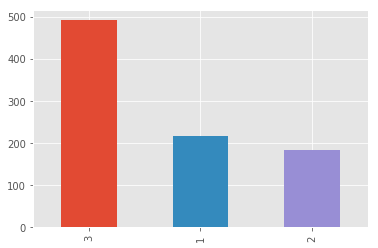

In [10]:
train.Pclass.value_counts().plot.bar()

Text(0.5,1,'Age distribution')

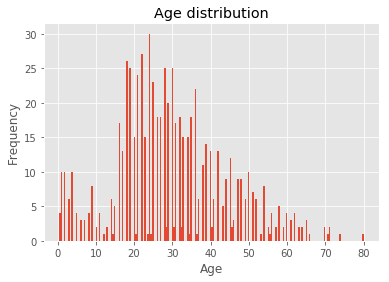

In [11]:
train.Age.plot.hist(bins = 200)
plt.xlabel("Age")
plt.title("Age distribution")

In [12]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


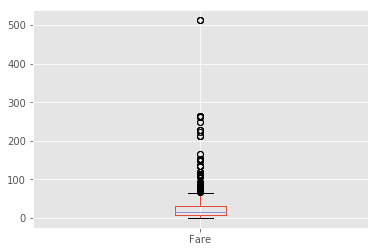

In [13]:
train.Fare.plot.box()

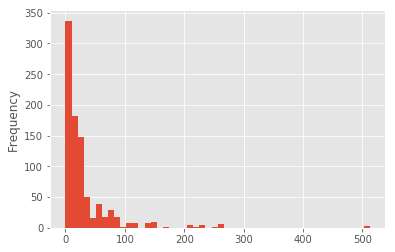

In [14]:
train.Fare.plot.hist(bins=50)

In [15]:
fare_vs_class = train.groupby("Pclass")["Fare"].agg([np.mean,np.median,np.min,np.max,np.std])
fare_vs_class

,mean,median,amin,amax,std
Pclass,,,,,
1,84.154687,60.2875,0.0,512.3292,78.380373
2,20.662183,14.2500,0.0,73.5000,13.417399
3,13.675550,8.0500,0.0,69.5500,11.778142


Text(0,0.5,'Fare')

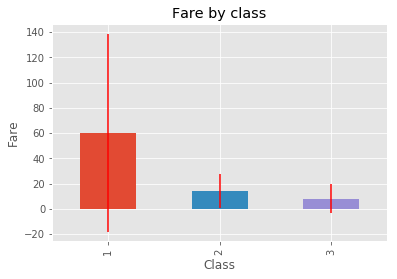

In [16]:
fare_vs_class["median"].plot.bar(yerr = fare_vs_class["std"], ecolor = "red")
plt.title("Fare by class")
plt.xlabel("Class")
plt.ylabel("Fare")

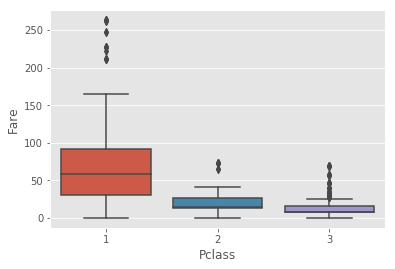

In [61]:
max_value = np.max(train['Fare'])
sns.boxplot("Pclass","Fare",data=train[train['Fare'] != max_value])

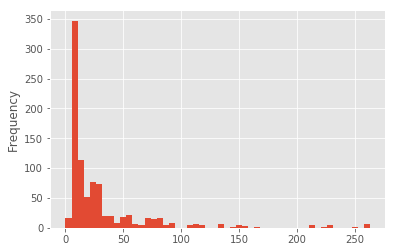

In [83]:
counts = dict()
for name in train['Name'].values:
    tokens = name.split()
    for token in tokens:
        counts[token] = counts.get(token, 0) + 1

counts = sorted(counts.items(),key = lambda kv:kv[1],reverse=True)
for (key,value) in counts:
    if value < 20:
        continue
    print(key)

Mr.
Miss.
Mrs.
William
John
Master.
Henry
James
Charles
George
Thomas


In [89]:
import re
counts = dict()
for name in train[train.Cabin.isna() == False]['Cabin'].values:
    name = re.sub('\d','',name)
    tokens = name.split()
    for token in tokens:
        counts[token] = counts.get(token, 0) + 1

counts = sorted(counts.items(),key = lambda kv:kv[1],reverse=True)
for (key,value) in counts:
    if value < 0:
        continue
    print(key," ",value)

C   71
B   64
D   34
E   33
A   15
F   13
G   7
T   1


In [97]:
import re
def cabin_class(cols):
    cabin = cols['Cabin']
    if pd.isna(cabin) == True:
        return "-"
    cabin = re.sub('\d','',cabin)
    tokens = set(cabin.split())
    final_cabin = ""
    for idx,token in enumerate(tokens):
        if idx == 0:
            final_cabin = token
        else:
            final_cabin = final_cabin +"_"+token
    return final_cabin

train['Cabin_Class'] = train.apply(cabin_class,axis=1)

In [98]:
train['Cabin_Class'].unique()

array(['-', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'G_F', 'F_E', 'T'],
      dtype=object)

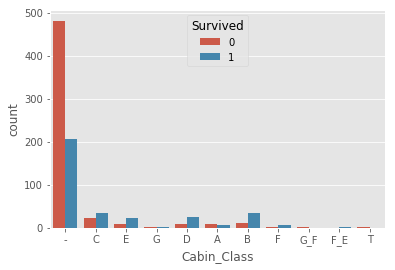

In [99]:
sns.countplot(x = 'Cabin_Class',hue='Survived',data=train)

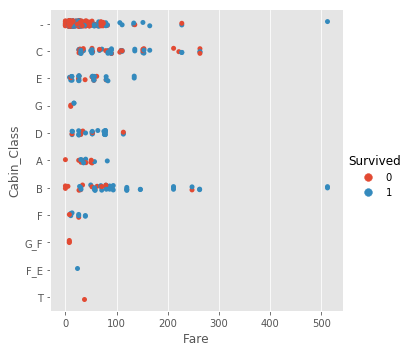

In [103]:
sns.catplot(y= 'Cabin_Class',x='Fare',data = train,hue = 'Survived')

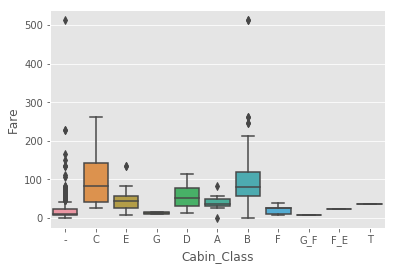

In [104]:
sns.boxplot(x= 'Cabin_Class',y='Fare',data=train)

In [133]:
(train['Cabin_Class'] == 'A')

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23      True
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
861    False
862    False
863    False
864    False
865    False
866    False
867     True
868    False
869    False
870    False
871    False
872    False
873    False
874    False
875    False
876    False
877    False
878    False
879    False
880    False
881    False
882    False
883    False
884    False
885    False
886    False
887    False
888    False
889    False
890    False
Name: Cabin_Class, Length: 891, dtype: bool

In [143]:
# index = (train['Cabin'].isna() == True)
index = (train['Cabin_Class'] == 'A')
train.loc[ index ,['Ticket','Cabin_Class','Cabin']].sample(np.min([20,sum(index)]))

,Ticket,Cabin_Class,Cabin
806,112050,A,A36
630,27042,A,A23
174,17764,A,A7
96,PC 17754,A,A5
583,13049,A,A10
867,PC 17590,A,A24
599,PC 17485,A,A20
209,112277,A,A31
185,113767,A,A32
647,13213,A,A26


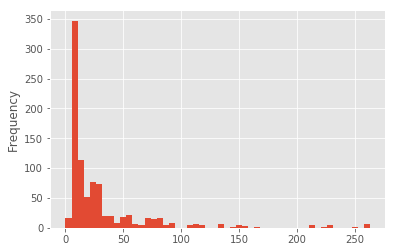

In [65]:
train[train['Fare'] != max_value].Fare.plot.hist(bins=50)

In [77]:
conditions = [(train['Fare'] <= 15) ,
              ((train['Fare'] > 15) & (train['Fare'] <= 130)),
              ((train['Fare'] > 130) & (train['Fare'] <= 250)),
              (train['Fare'] > 250)]
values = ['lo','medium','high','super-high']
train['Fclass'] = np.select(conditions,values)

In [78]:
train['Fclass'].value_counts()

lo            458
medium        395
high           29
super-high      9
Name: Fclass, dtype: int64

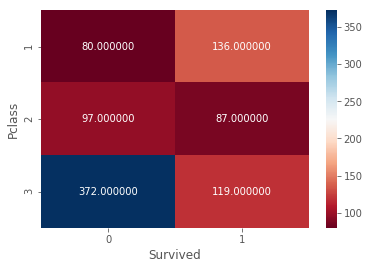

In [71]:
Pclass_vs_survival = train.groupby(["Pclass", "Survived"])["PassengerId"].agg(len).unstack().fillna(0)
sns.heatmap(Pclass_vs_survival, cmap=sns.color_palette("RdBu", 1000), annot=True,fmt='f')

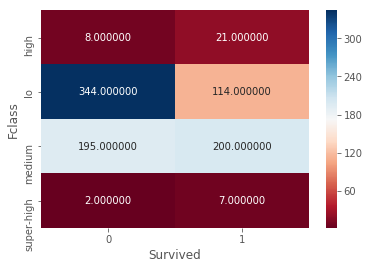

In [79]:
Fclass_vs_survival  = train.groupby(["Fclass","Survived"])["PassengerId"].agg(len).unstack()
sns.heatmap(Fclass_vs_survival,cmap = sns.color_palette("RdBu",1000),annot= True,fmt='f')

In [37]:
aggr = train.dropna().groupby('Pclass')['Age'].agg([np.median])
aggr

,median
Pclass,
1,36.0
2,28.0
3,26.0


In [24]:
medians = (train[train.Sex == 'female']['Age'].dropna().median(),train[train.Sex == 'male']['Age'].dropna().median())
medians

(27.0, 29.0)

In [25]:
train['Age'].fillna(27.0,inplace=True)

In [27]:
target = 'Survived'
features = list(train.columns)
features.remove('PassengerId')
features.remove('Name')
features.remove('Cabin')
features.remove('Ticket')
features.remove(target)
features , target

(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Fclass'],
 'Survived')

In [28]:
X = train.loc[:,features]
y = train.loc[:,target]
X.shape,y.shape

((891, 8), (891,))

In [29]:
X = pd.get_dummies(X, drop_first= True)
X.shape

(891, 11)

In [31]:
X_train,X_test,y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 1)

In [32]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
outcome = pd.DataFrame({"actual": y_test,"pred": y_test_pred}) 
outcome["match"] = outcome.actual == outcome.pred
outcome.sample(10)

,actual,pred,match
294,0,0,True
8,1,1,True
61,1,1,True
3,1,1,True
599,1,0,False
888,0,1,False
719,0,0,True
803,1,0,False
637,0,0,True
16,0,0,True


In [35]:
metrics.confusion_matrix(y_true=y_test,y_pred=y_test_pred)

array([[135,  18],
       [ 39,  76]], dtype=int64)

In [34]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
342/(342+549)

In [36]:
metrics.accuracy_score(y_true=y_test,y_pred=y_test_pred)

0.7873134328358209

In [ ]:
# plot_decision_regions(X_train,y_train,X_highlight=X_train)